In [1]:
import os
from pathlib import Path
from typing import List, Union

import numpy as np
import torch
from torch import nn
from sklearn.metrics import roc_auc_score
from scipy.stats import wasserstein_distance

import matplotlib.pyplot as plt

from hopfield_boosting.energy import OneSidedEnergy
from hopfield_boosting.utils.plot_util import plot_histograms, create_subplots, ax2ax
from hopfield_boosting.utils.model_util import model_file, load_model, create_model, load_model_weights
from hopfield_boosting.utils.eval_util import eval_metrics_str, dump_eval_metrics
from hopfield_boosting.utils.config_util import ConstOmegaConfLoader
from hopfield_boosting.util import infer_loader
from hopfield_boosting.ood.metrics import FPR95OODMetric

# Energy-based Hopfield Boosting for Out-of-Distribution Detection - Demo Notebook

This demo is made for reproducing the results of Hopfield boosting on SVHN using a pre-trained model and to give an initial setup for further experiments. The pre-trained model is available for download [here](https://drive.google.com/file/d/1LK1VyjvQfA3qUG8LGue0IBOy0Sja2GJb/view?usp=sharing).

## Environment Setup

First, we set up the environment and all paths to the data sets.

In [2]:
# Environment configuration
cfg = ConstOmegaConfLoader("hopfield_boosting_notebook_config.yaml").config

# change your name here to load your personal config
cfg = cfg.your_name

BASE_MODEL_PATH = Path(cfg.BASE_MODEL_PATH)
CIFAR_ROOT = Path(cfg.CIFAR_ROOT)
IMAGENET_ROOT = Path(cfg.IMAGENET_ROOT)
SVHN_ROOT = Path(cfg.SVHN_ROOT)
PLACES_ROOT = Path(cfg.PLACES_ROOT)
ICARTOONFACE_ROOT = Path(cfg.ICARTOONFACE_ROOT)
RPC_ROOT = Path(cfg.RPC_ROOT)
SHAPES3D_ROOT = Path(cfg.SHAPES3D_ROOT)
FOUR_SHAPES_ROOT = Path(cfg.FOUR_SHAPES_ROOT)
AFHQV2_ROOT = Path(cfg.AFHQV2_ROOT)
MOEIMOUTO_FACES_ROOT = Path(cfg.MOEIMOUTO_FACES_ROOT)
IMAGENETO_ROOT = Path(cfg.IMAGENETO_ROOT)
CUDA_VISIBLE_DEVICES = cfg.CUDA_VISIBLE_DEVICES
if CUDA_VISIBLE_DEVICES:
    os.environ['CUDA_VISIBLE_DEVICES'] = CUDA_VISIBLE_DEVICES

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

Running on device: CUDA


## Instantiate model

A pre-trained model is available for download [here](https://drive.google.com/file/d/187oVPp04d8_1_weGnnj01iMAEjIct9G4/view?usp=sharing)

In [4]:
# create model. We do NOT load the model weights yet. This is for illustration purposes

model_id = Path('pre-trained')
model_path = BASE_MODEL_PATH / model_id
#config, resnet, projection_head, classifier = create_model(model_id)
config, resnet, projection_head, classifier = create_model(model_path, device=DEVICE)

**All model components are randomly initialized at this point**

In [5]:
resnet # Resnet18_32x32 from OpenOOD with CIFAR-normalization built-in

CNNOODWrapper(
  (module): ResNet18_32x32(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False

In [6]:
projection_head # 2-layer MLP that connects the Resnet output (512d) with the Hopfield Head (128d)

MLP(
  (in_layer): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
  )
  (out_layer): Linear(in_features=256, out_features=128, bias=True)
  (hidden): Sequential()
  (model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential()
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
)

In [7]:
classifier # linear layer that maps the Resnet-18 output (512d) to the 10 CIFAR-10 classes

Linear(in_features=512, out_features=10, bias=True)

## Dataset setup

In [8]:
# instantiate data sets
from torchvision.datasets import CIFAR10, ImageFolder#, SVHN   # import this version of SVHN to use the default test set
from torchvision import transforms

from hopfield_boosting.data.datasets import ImageNet
from hopfield_boosting.data.datasets.svhn import SVHN

# create CIFAR-10 training and testing datasets + loaders
cifar_train = CIFAR10(CIFAR_ROOT, train=True, transform=transforms.Compose([transforms.ToTensor()]))
cifar_test = CIFAR10(CIFAR_ROOT, train=False, transform=transforms.Compose([transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=1024, shuffle=False, drop_last=False)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=1024, shuffle=False, drop_last=False)


# create Imagenet dataset + loader
ood_data = ImageNet(root=IMAGENET_ROOT,
                    transform=transforms.Compose([transforms.CenterCrop(32), transforms.ToTensor()]))
ood_loader = torch.utils.data.DataLoader(ood_data, batch_size=1000, shuffle=True)

# create SVHN test dataset + loader
# this version of SVHN contains 10000 data instances pre-selected for reproducible OOD performance evaluation
# you can also use the default SVHN test set by importing SVHN from Torchvision, the only thing is that then the CIFAR and SVHN test sets are unbalanced
svhn = SVHN(
    SVHN_ROOT,
    split='test',
    download=False,
    transform=transforms.Compose([transforms.ToTensor()])
)
svhn_loader = torch.utils.data.DataLoader(svhn, batch_size=1024, shuffle=False)

places = ImageFolder(
    root=PLACES_ROOT,
    transform=transforms.Compose([transforms.Resize(32), transforms.CenterCrop(32), transforms.ToTensor()])
)
places = torch.utils.data.Subset(
    places,
    indices=np.random.choice(a=len(places), size=10000, replace=False)
)

places_loader = torch.utils.data.DataLoader(places, batch_size=1024, shuffle=False)

## Energy on randomly initialized model

First, we would like to demonstrate how the energy behaves on the **randomly initialized** model. To do this, we

1. Create some embeddings on the randomly initialized ResNet-18 using CIFAR-10 train and Imagenet
2. Use the embeddings to create a torch.nn.Module that can compute the score $s(\mathbb{\xi})$ arbitrary patterns.
3. Compute the energies on CIFAR-10 test and Imagenet
4. Look at the distributions of the energies of CIFAR-10 and Imagenet

In [9]:
# we now create some embeddings that we can use to compute the Hopfield Energy
# for simplicity, we use the full CIFAR-10 training dataset and a randomly sampled subset of ImageNet of equal size
from hopfield_boosting.util import infer_loader

# to create embeddings for the Hopfield network, we feed the data to the resnet and then through the projection head
embedding_model = nn.Sequential(resnet, projection_head)

# infer_loader iterates over the loader and creates the embeddings
cifar_embeddings = infer_loader(train_loader, embedding_model, device=DEVICE).__enter__()
ood_embeddings = infer_loader(ood_loader, embedding_model, device=DEVICE, max_samples=len(cifar_train)).__enter__()

In [10]:
print(cifar_embeddings.shape)
print(ood_embeddings.shape)

torch.Size([50000, 128])
torch.Size([50000, 128])


In [11]:
# we can create a variety of Hopfield energy functions of different combination of distributions

# we can define different values of beta for the two datasets. Here, we will use the same beta as during training
cifar_beta = config.beta
ood_beta = config.beta

# OneSidedEnergy estimates the difference of energies of patterns in the CIFAR embeddings and the Imagenet embeddings
cifar_vs_ood_energy_fn = OneSidedEnergy(a=cifar_embeddings, b=ood_embeddings, beta_a=cifar_beta, beta_b=ood_beta)

In [12]:
# cifar_vs_imagenet_energy_fn is a torch.nn.Module which takes an embedding from our Resnet-18 and returns its energy (and some additional information)

cifar_vs_ood_energy_fn(cifar_embeddings[0:1])

tensor([-0.0017], device='cuda:0')

In [13]:
# we now compute the energies of the testset of CIFAR-10 and a subset of Imagenet of equal size

cifar_vs_ood_energy_model = nn.Sequential(resnet, projection_head, cifar_vs_ood_energy_fn)

cifar_test_cifar_train_energy = infer_loader(test_loader, cifar_vs_ood_energy_model, device=DEVICE).__enter__().cpu()
ood_cifar_train_energy = infer_loader(ood_loader, cifar_vs_ood_energy_model, device=DEVICE, max_samples=len(cifar_test)).__enter__().cpu()

In [14]:
labels = np.concatenate([np.zeros(len(cifar_test_cifar_train_energy)), np.ones(len(ood_cifar_train_energy))], axis=0)
score = np.concatenate([cifar_test_cifar_train_energy, ood_cifar_train_energy], axis=0)
print(f'AUROC: {roc_auc_score(labels, score)}')
print(f'Wasserstein distance: {wasserstein_distance(cifar_test_cifar_train_energy, ood_cifar_train_energy)}')

AUROC: 0.54863065
Wasserstein distance: 0.00020403702259063716


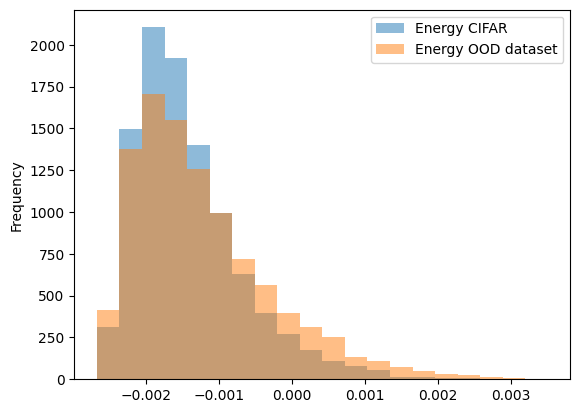

In [15]:
fig = plot_histograms([cifar_test_cifar_train_energy.cpu(), ood_cifar_train_energy.cpu()],
                      ["Energy CIFAR", "Energy OOD dataset"],
                      bins=20)

We can see that there seems to be a very slight difference in energies between CIFAR-10 and Imagenet *at model initialization*. Hopfield Boosting detects the difference in energies and amplifies them.

## Energy with trained model

Now, we load the weights of a trained model to look at the OOD detection performance after training

In [16]:
#_ = load_model_weights(model_id, resnet, projection_head, classifier, device=DEVICE)
_ = load_model_weights(model_path, resnet, projection_head, classifier, device=DEVICE)

In [17]:
# test model and verify test accuracy
classification_model = nn.Sequential(resnet, classifier)

predictions = []
ys = []
for x, y in test_loader:
    x = x.to(DEVICE)
    ys.append(y)
    logits = classification_model(x)
    predictions.append(torch.argmax(logits, dim=-1).cpu())

prediction = torch.concat(predictions, dim=0)
ys = torch.concat(ys, dim=0)
print(f'Accuracy: {(prediction == ys).float().mean()}')

Accuracy: 0.9362000226974487


In [18]:
from sklearn.metrics import classification_report

print(classification_report(ys, prediction, digits=3))

              precision    recall  f1-score   support

           0      0.934     0.947     0.940      1000
           1      0.961     0.974     0.967      1000
           2      0.928     0.914     0.921      1000
           3      0.860     0.873     0.867      1000
           4      0.933     0.950     0.942      1000
           5      0.881     0.892     0.886      1000
           6      0.963     0.955     0.959      1000
           7      0.978     0.947     0.962      1000
           8      0.961     0.961     0.961      1000
           9      0.967     0.949     0.958      1000

    accuracy                          0.936     10000
   macro avg      0.937     0.936     0.936     10000
weighted avg      0.937     0.936     0.936     10000



In [19]:
# infer_loader iterates over the loader and creates the embeddings
cifar_embeddings = infer_loader(train_loader, embedding_model, device=DEVICE).__enter__()
ood_embeddings = infer_loader(ood_loader, embedding_model, device=DEVICE, max_samples=len(cifar_train)).__enter__()

In [20]:
# OneSidedEnergy estimates the difference of energies of patterns in the CIFAR embeddings and the Imagenet embeddings
cifar_ood_classification_energy = OneSidedEnergy(a=cifar_embeddings, b=ood_embeddings, beta_a=cifar_beta, beta_b=ood_beta)

In [22]:
cifar_energy_model = nn.Sequential(resnet, projection_head, cifar_ood_classification_energy)

cifar_test_cifar_train_energy = infer_loader(test_loader, cifar_energy_model, device=DEVICE).__enter__().cpu()
ood_cifar_train_energy = infer_loader(ood_loader, cifar_energy_model, device=DEVICE, max_samples=len(cifar_test)).__enter__().cpu()

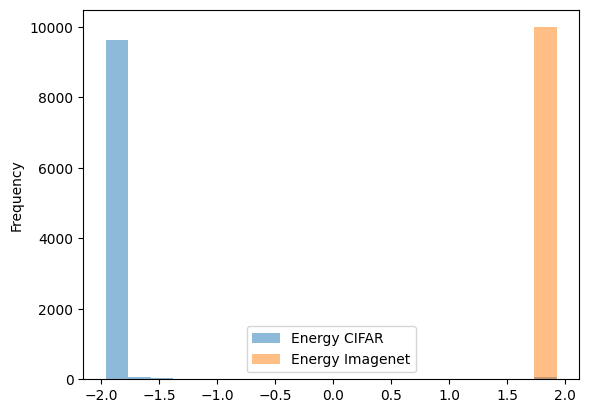

In [23]:
fig = plot_histograms([cifar_test_cifar_train_energy.cpu(), ood_cifar_train_energy.cpu()],
                      ["Energy CIFAR", "Energy Imagenet"],
                      bins=20);

## Evaluation with SVHN data set

In [24]:
svhn_cifar_train_energy = infer_loader(svhn_loader, cifar_energy_model, device=DEVICE).__enter__().cpu()

AUROC: 0.9970449399999999
Wasserstein distance: 3.709907171082496


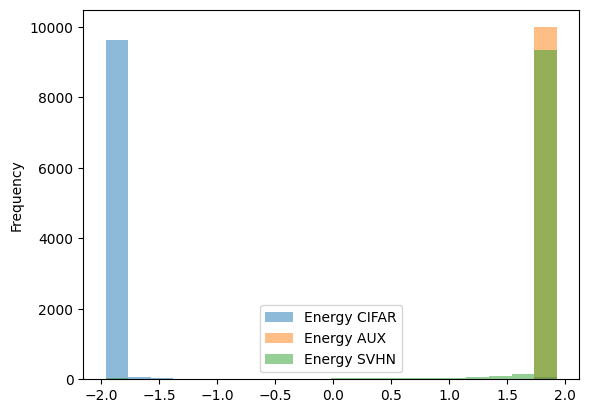

In [25]:
fig = plot_histograms([cifar_test_cifar_train_energy.cpu(), ood_cifar_train_energy.cpu(), svhn_cifar_train_energy.cpu()],
                      ["Energy CIFAR", "Energy AUX", "Energy SVHN"],
                      bins=20)

# compute AUROC and Wasserstein distance between the two classes
labels = np.concatenate([np.zeros(len(cifar_test_cifar_train_energy)), np.ones(len(svhn_cifar_train_energy))], axis=0)
score = np.concatenate([cifar_test_cifar_train_energy, svhn_cifar_train_energy], axis=0)
print(f'AUROC: {roc_auc_score(labels, score)}')
print(f'Wasserstein distance: {wasserstein_distance(cifar_test_cifar_train_energy, svhn_cifar_train_energy)}')

## Evaluation with Places data set

In [26]:
places_cifar_train_energy = infer_loader(places_loader, cifar_energy_model, device=DEVICE).__enter__().cpu()

AUROC: 0.9858368550000001
Wasserstein distance: 3.1941213253259657


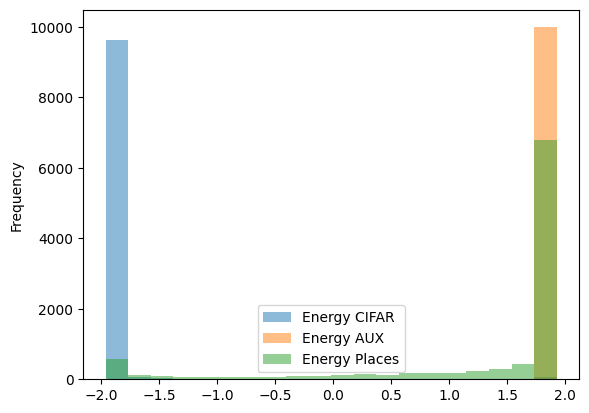

In [27]:
fig = plot_histograms([cifar_test_cifar_train_energy.cpu(), ood_cifar_train_energy.cpu(), places_cifar_train_energy.cpu()],
                      ["Energy CIFAR", "Energy AUX", "Energy Places"],
                      bins=20)

# compute AUROC and Wasserstein distance between the two classes
labels = np.concatenate([np.zeros(len(cifar_test_cifar_train_energy)), np.ones(len(places_cifar_train_energy))], axis=0)
score = np.concatenate([cifar_test_cifar_train_energy, places_cifar_train_energy], axis=0)
print(f'AUROC: {roc_auc_score(labels, score)}')
print(f'Wasserstein distance: {wasserstein_distance(cifar_test_cifar_train_energy, places_cifar_train_energy)}')

### Zoom to in-distribution class

(0.0, 200.0)

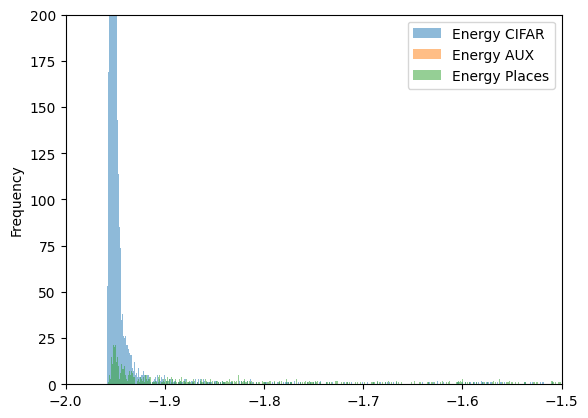

In [28]:
# zoom in to in-distribution class.

fig = plot_histograms([cifar_test_cifar_train_energy.cpu(), ood_cifar_train_energy.cpu(), places_cifar_train_energy.cpu()],
                      ["Energy CIFAR", "Energy AUX", "Energy Places"],
                      bins=5000)

plt.xlim(-2., -1.5)
plt.ylim(0, 200)

### Look at wrongly predicted samples

In [29]:
# This only works when the "shuffle" parameter in the torch DataLoader is set to False!

badly_predicted_energies, badly_predicted_samples = torch.sort(places_cifar_train_energy, descending=False)

<Figure size 2000x2000 with 0 Axes>

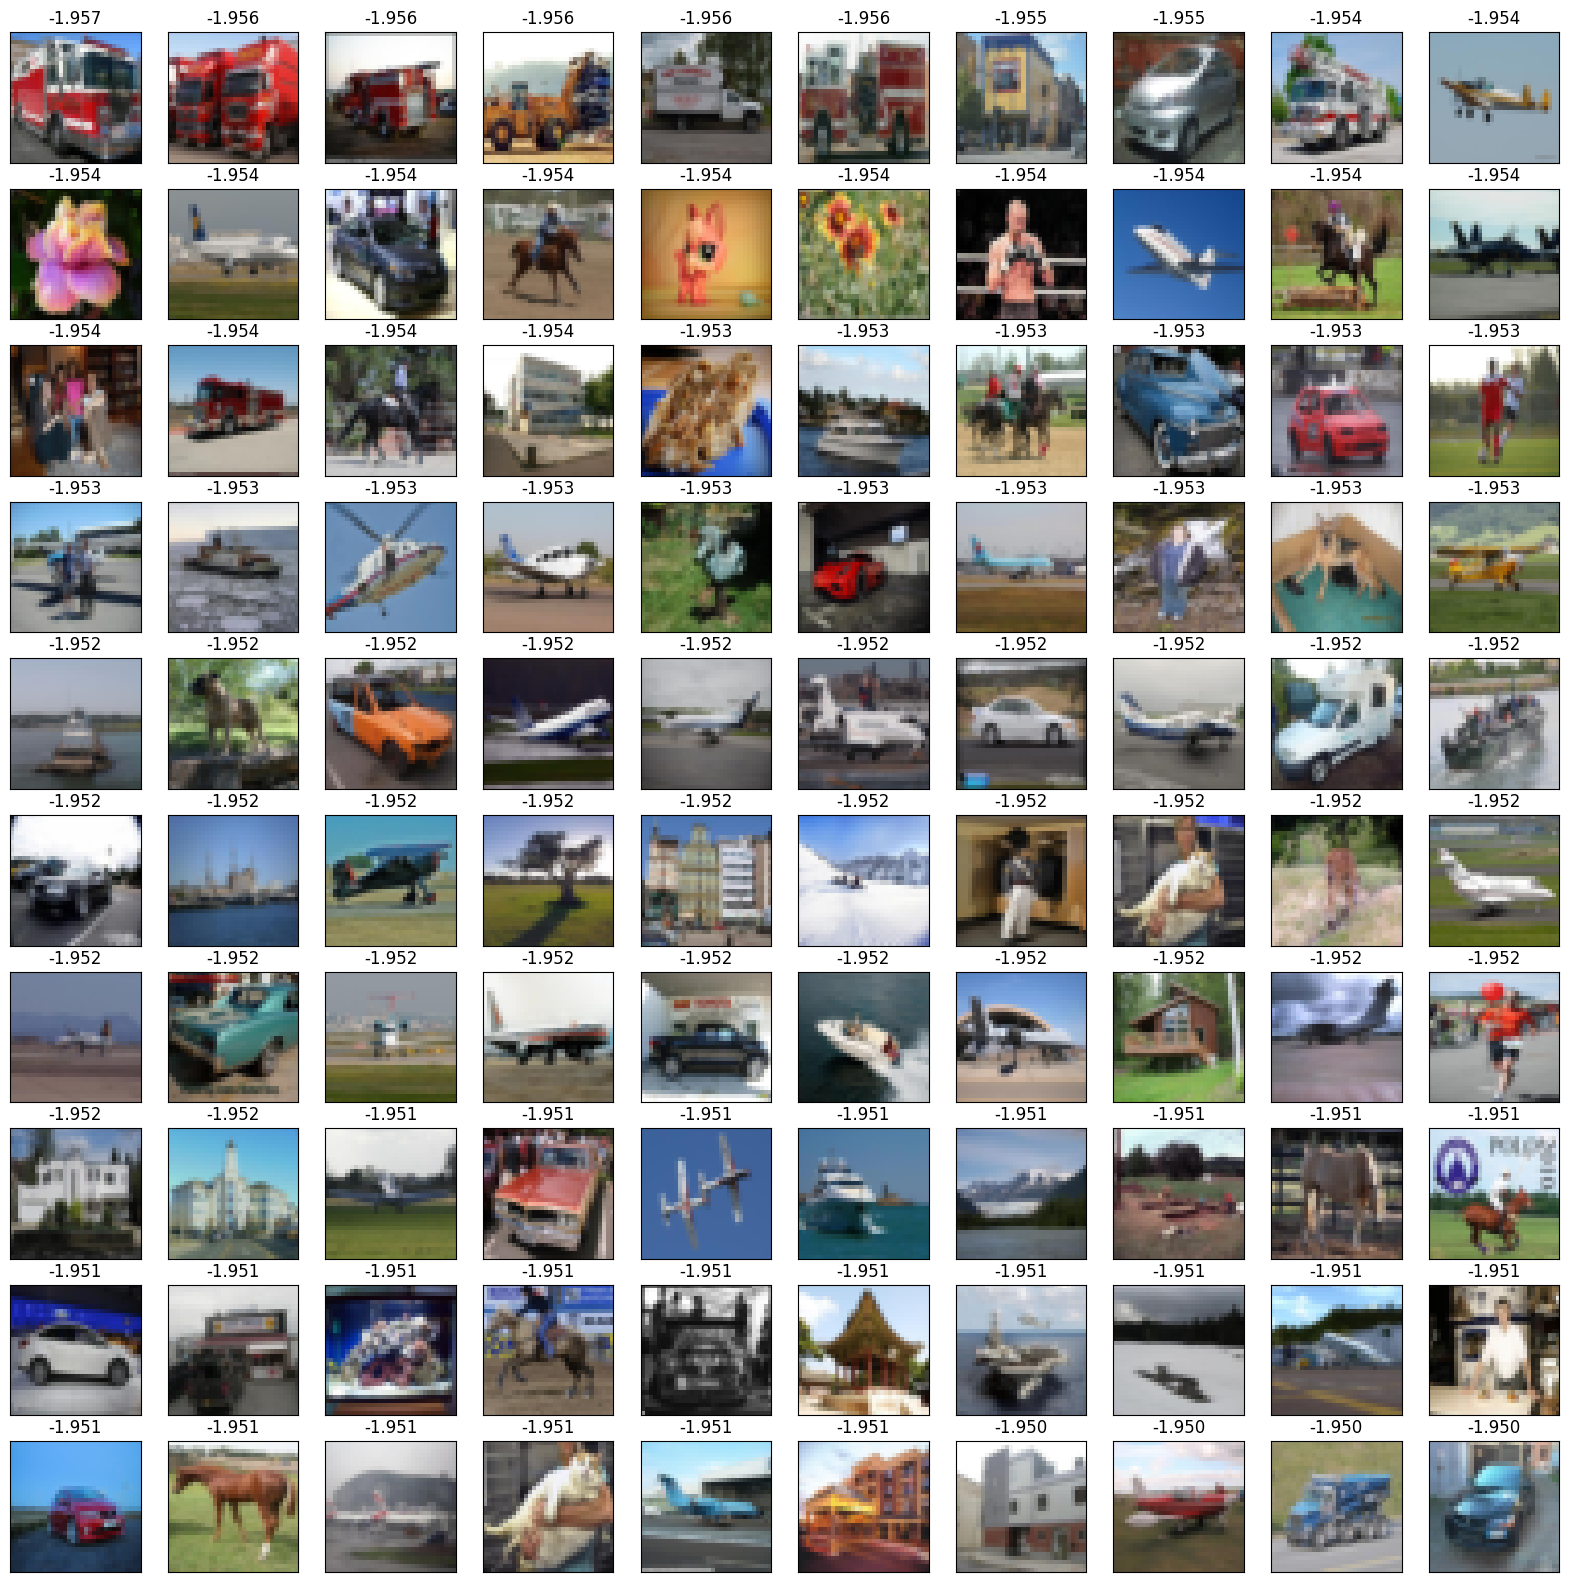

In [30]:
nrows = 10
ncols = 10

_ = plt.figure(figsize=(20, 20))
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 20))

for row in range(nrows):
    for col in range(ncols):
        image, _ = places[badly_predicted_samples[row * nrows + col]]
        image = transforms.ToPILImage()(image)
        axes[row][col].imshow(image)
        energy = float(badly_predicted_energies[row * nrows + col])
        axes[row][col].set_title("{:.3f}".format(energy))
        axes[row][col].tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 

## Evaluation with icartoonface data set
https://github.com/luxiangju-PersonAI/iCartoonFace

In [31]:
random_state = 23
np.random.seed(random_state)

In [32]:
def eval_energy_model(data_path,
                        transform=transforms.Compose([transforms.Resize(32), transforms.CenterCrop(32), transforms.ToTensor()]),
                        subset_size=10000,
                        replace=False,
                        energy_model=None,
                        device=DEVICE,
                        ):
    data_set =  ImageFolder(root=data_path, transform=transform)
    data_set = torch.utils.data.Subset(data_set, indices=np.random.choice(a=len(data_set), size=subset_size, replace=replace))

    data_loader = torch.utils.data.DataLoader(data_set, batch_size=1024, shuffle=False)

    energy = infer_loader(data_loader, energy_model, device=device).__enter__().cpu()

    return data_set, data_loader, energy


def plot_eval_hist(energy, label):
    fig = plot_histograms([cifar_test_cifar_train_energy.cpu(), ood_cifar_train_energy.cpu(), energy.cpu()],
                        ["Energy CIFAR", "Energy AUX", label],
                        bins=20)

    # compute AUROC and Wasserstein distance between the two classes
    labels = np.concatenate([np.zeros(len(cifar_test_cifar_train_energy)), np.ones(len(energy))], axis=0)
    score = np.concatenate([cifar_test_cifar_train_energy, energy], axis=0)
    fpr95_metric = FPR95OODMetric()
    print(f'AUROC: {roc_auc_score(labels, score)}')
    print(f'FPR95: {fpr95_metric(-cifar_test_cifar_train_energy, -energy)}')
    print(f'Wasserstein distance: {wasserstein_distance(cifar_test_cifar_train_energy, energy)}')    

In [33]:
def plot_random_samples(dataset, n_samples):
    # Randomly sample indices
    num_images = len(dataset)
    sampled_indices = torch.randperm(num_images)[:n_samples]

    # Extract images and labels
    sampled_images = [dataset[i][0] for i in sampled_indices]
    sampled_labels = [dataset[i][1] for i in sampled_indices]

    # Create the layout of subplots
    fig, axes = create_subplots(n_samples, rotate=False)

    for i in range(n_samples):
        ax = axes[i]
        ax.imshow(np.transpose(sampled_images[i], (1, 2, 0)))
        ax.set_title(f'Label: {sampled_labels[i]}')
        ax.axis('off')

    return fig

AUROC: 0.995651385
FPR95: 0.0066
Wasserstein distance: 3.5998757109045982


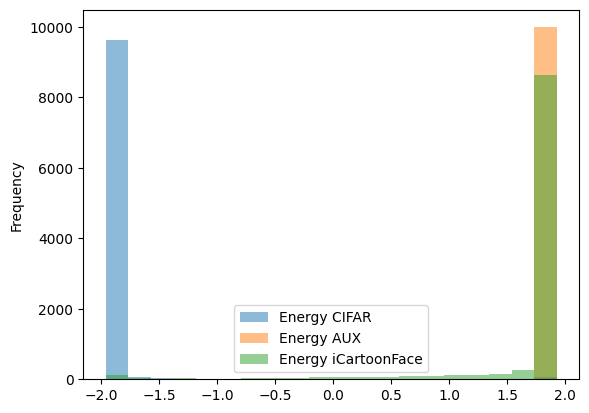

In [34]:
icartoonface, icartoonface_loader, icartoonface_cifar_train_energy = eval_energy_model(
    data_path=ICARTOONFACE_ROOT,
    energy_model=cifar_energy_model,
    )

plot_eval_hist(icartoonface_cifar_train_energy, "Energy iCartoonFace")    

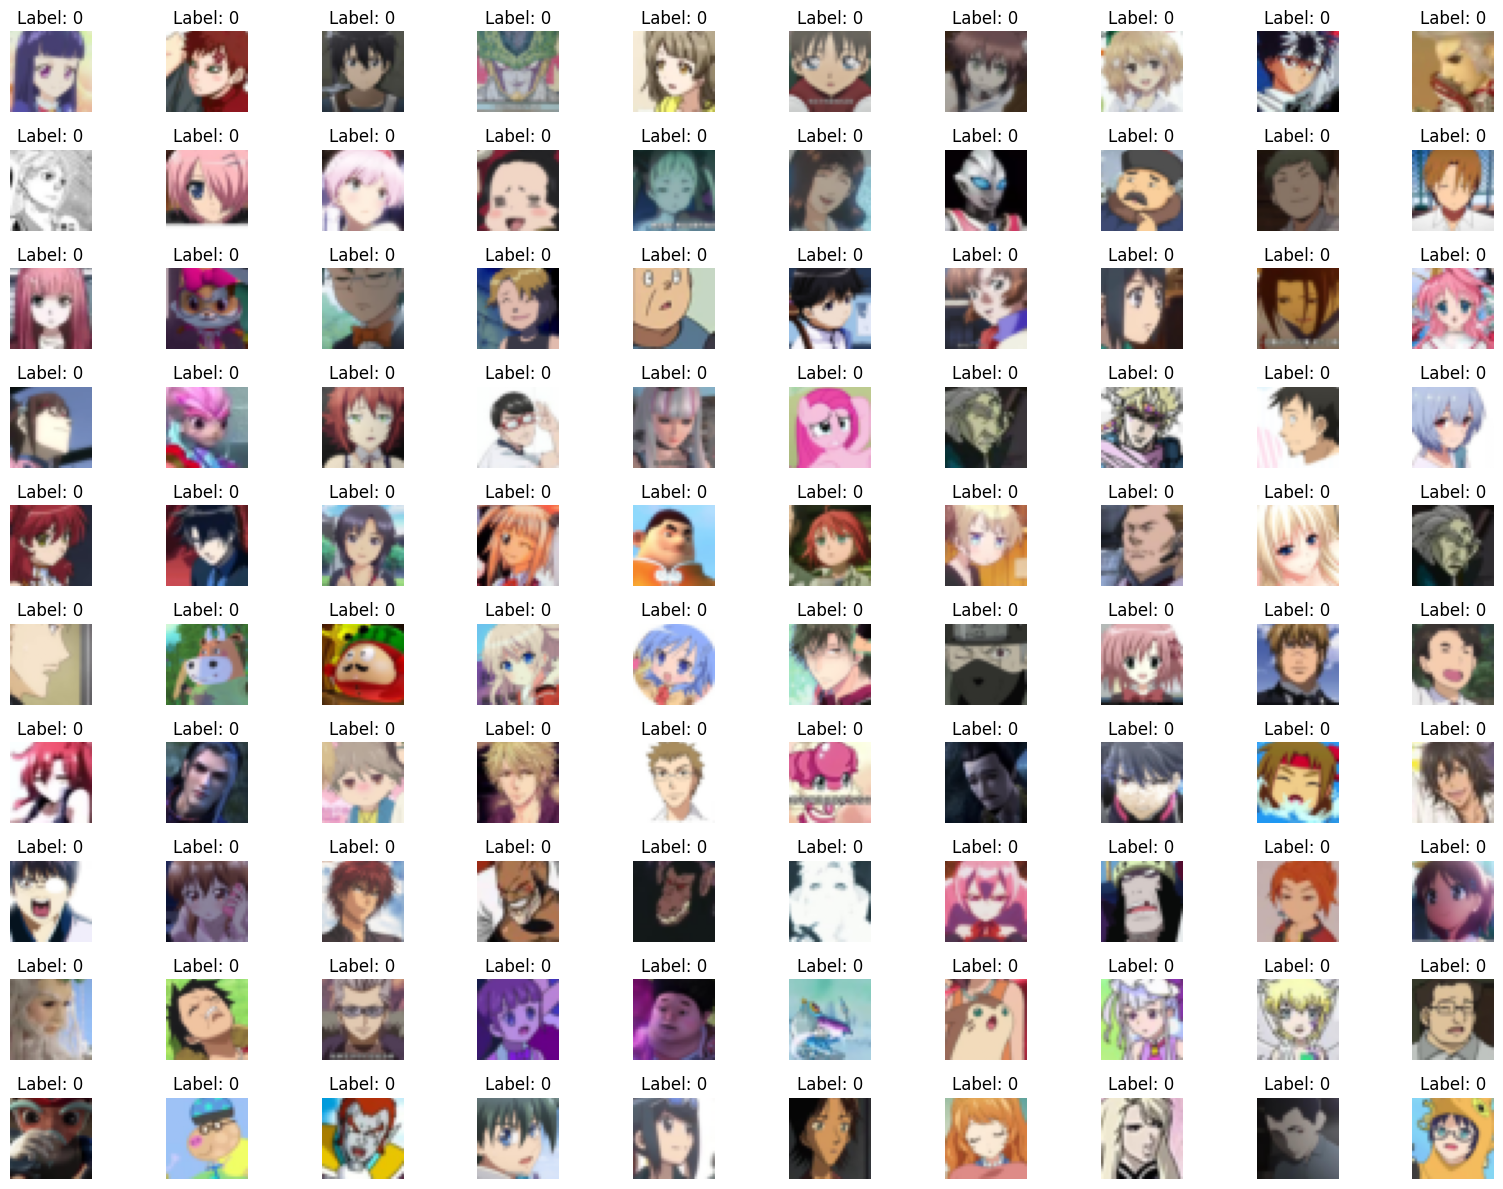

In [35]:
fig = plot_random_samples(icartoonface, 100)

fig.set_size_inches(16, 12)
#plt.suptitle("Augmentation Effects on Hopfield Energy")

plt.tight_layout()
plt.show()

## Evaluation with RPC data set
https://rpc-dataset.github.io/

AUROC: 0.98666916
FPR95: 0.0426
Wasserstein distance: 2.9479994668245313


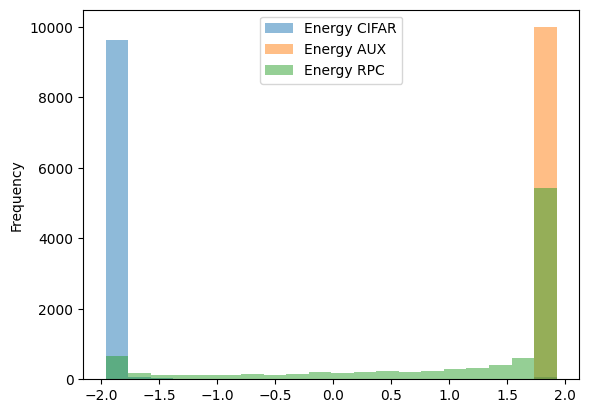

In [36]:
rpc, rpc_loader, rpc_cifar_train_energy = eval_energy_model(
    data_path=RPC_ROOT,
    energy_model=cifar_energy_model,
    )

plot_eval_hist(rpc_cifar_train_energy, "Energy RPC")    

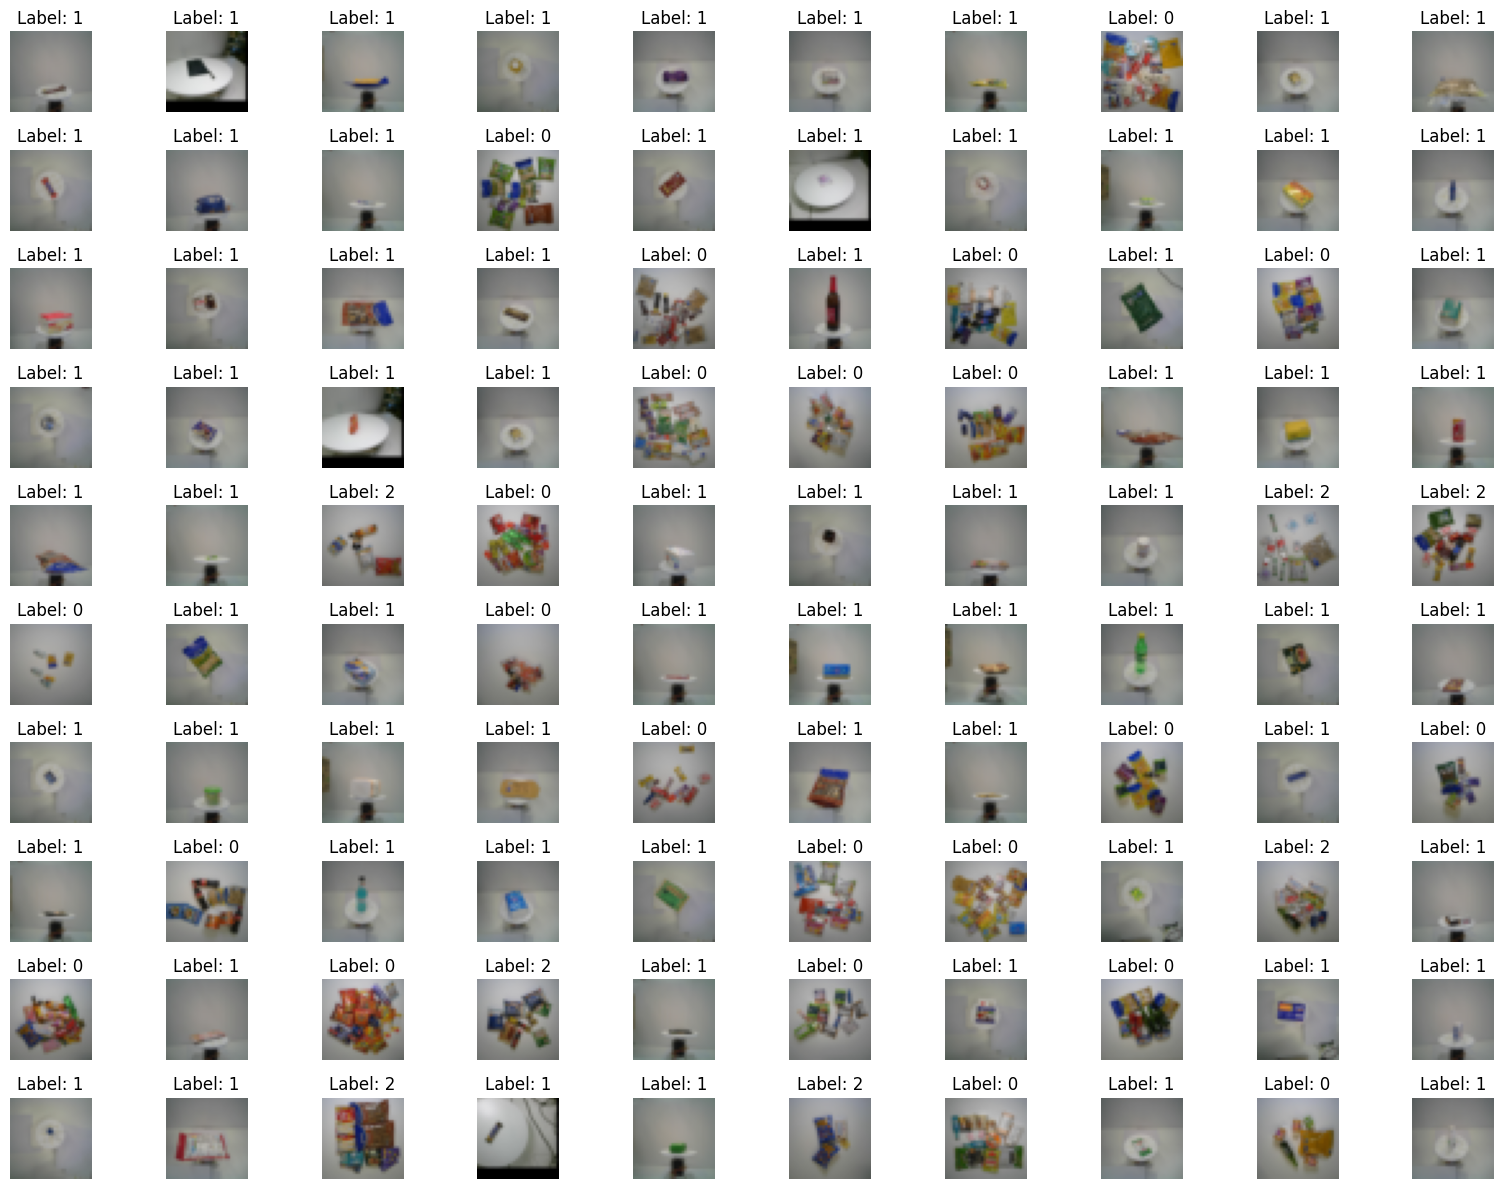

In [37]:
fig = plot_random_samples(rpc, 100)

fig.set_size_inches(16, 12)
#plt.suptitle("Augmentation Effects on Hopfield Energy")

plt.tight_layout()
plt.show()

## Evaluation with 3D Shapes data set
https://github.com/google-deepmind/3d-shapes

AUROC: 0.99795042
FPR95: 0.0001
Wasserstein distance: 3.7625691200494766


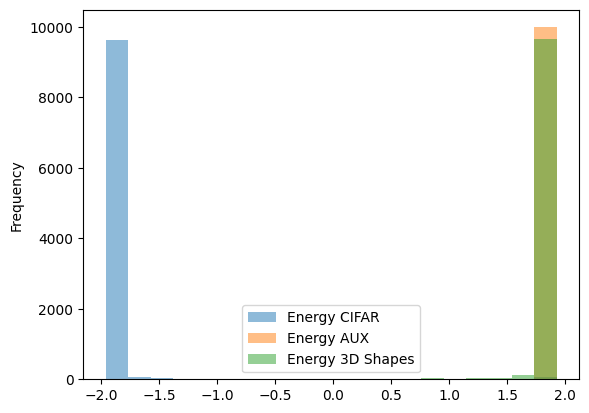

In [38]:
shapes3d, shapes3d_loader, shapes3d_cifar_train_energy = eval_energy_model(
    data_path=SHAPES3D_ROOT,
    energy_model=cifar_energy_model,
    )

plot_eval_hist(shapes3d_cifar_train_energy, "Energy 3D Shapes")    

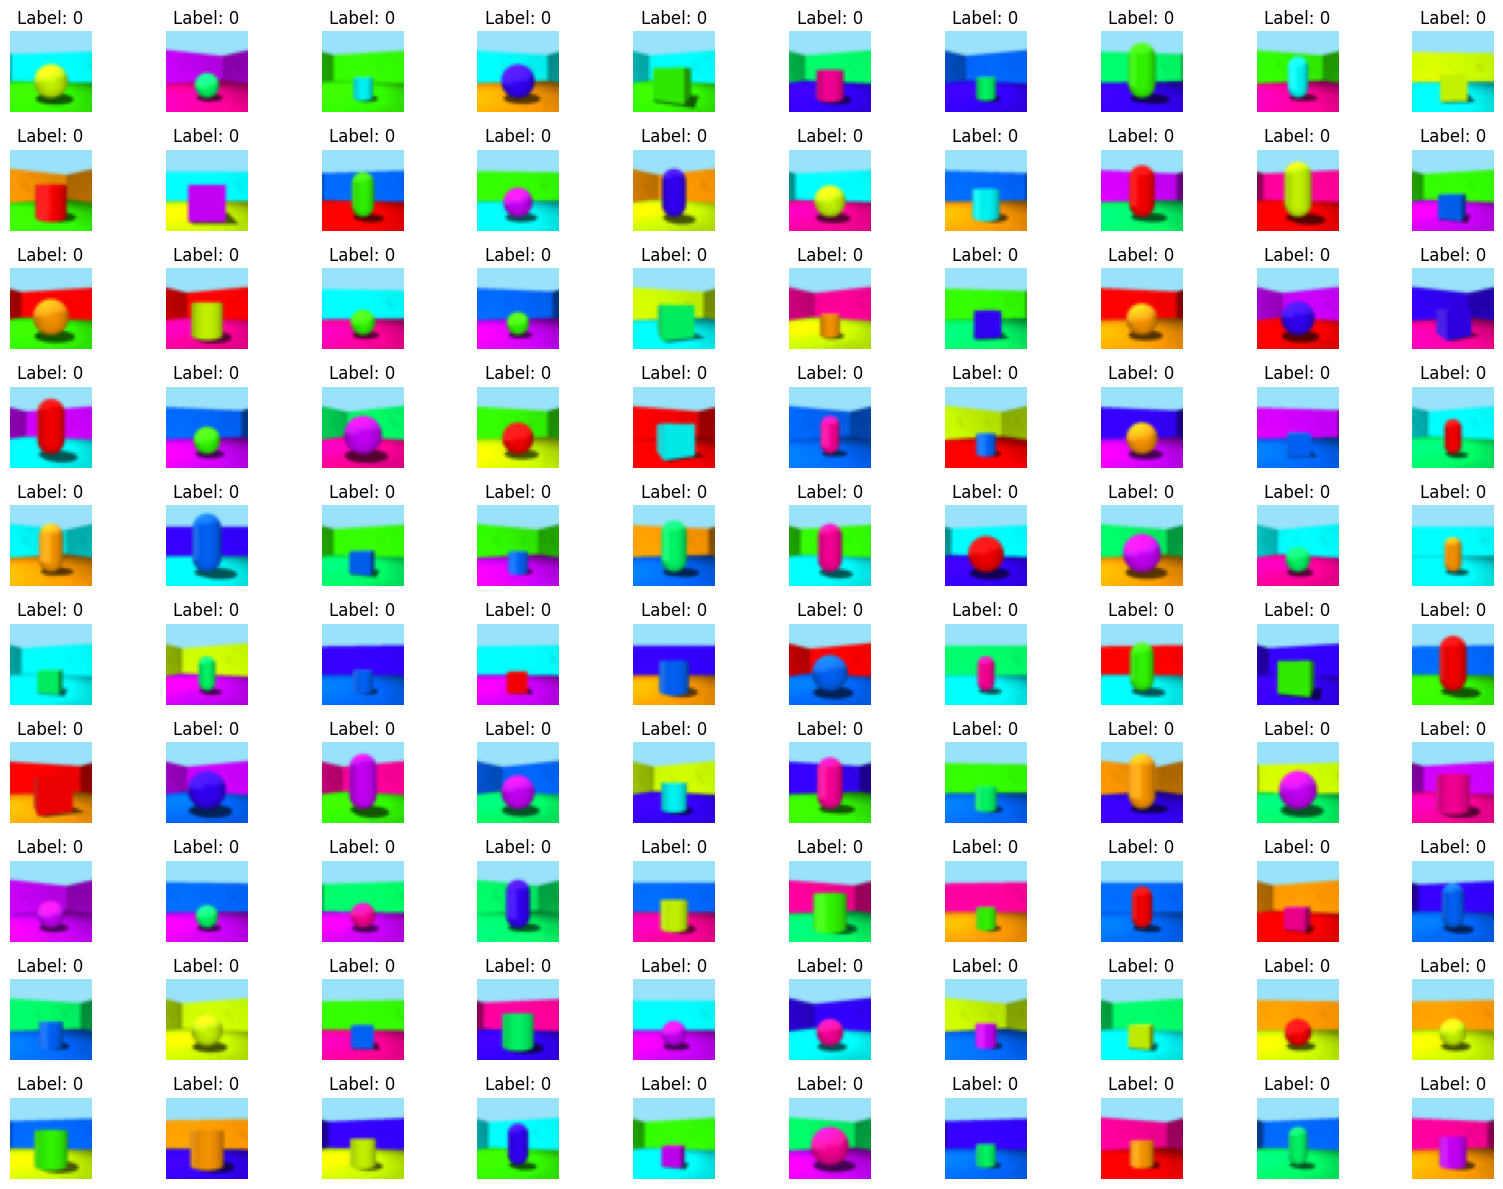

In [39]:
fig = plot_random_samples(shapes3d, 100)

fig.set_size_inches(16, 12)
#plt.suptitle("Augmentation Effects on Hopfield Energy")

plt.tight_layout()
plt.show()

## Evaluation with Four Shapes data set
https://www.kaggle.com/datasets/smeschke/four-shapes

AUROC: 0.904213695
FPR95: 0.4138
Wasserstein distance: 1.5808867920279503


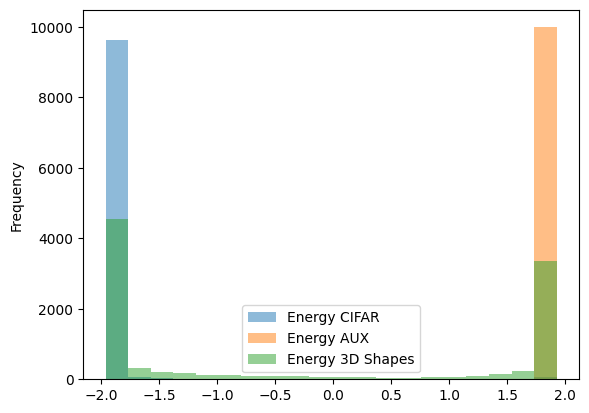

In [40]:
four_shapes, four_shapes_loader, four_shapes_cifar_train_energy = eval_energy_model(
    data_path=FOUR_SHAPES_ROOT,
    energy_model=cifar_energy_model,
    )

plot_eval_hist(four_shapes_cifar_train_energy, "Energy 3D Shapes")    

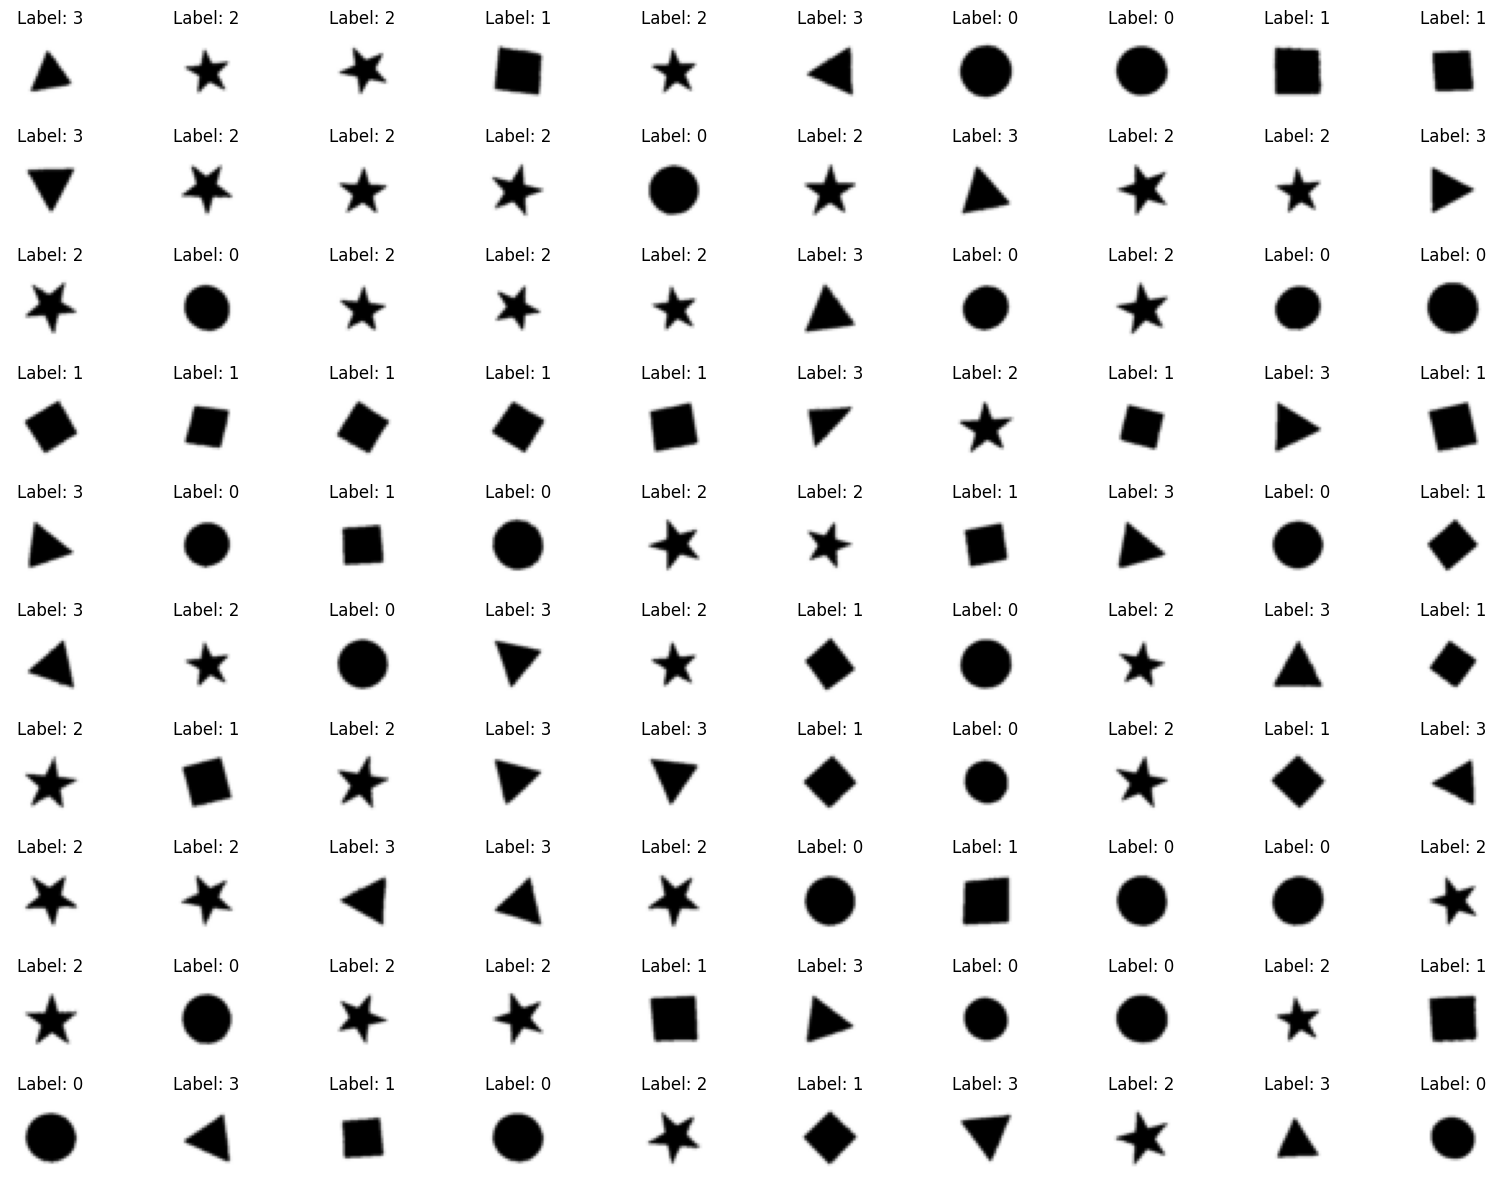

In [41]:
fig = plot_random_samples(four_shapes, 100)

fig.set_size_inches(16, 12)
#plt.suptitle("Augmentation Effects on Hopfield Energy")

plt.tight_layout()
plt.show()

## Evaluation with AFHQ_V2 data set
https://github.com/clovaai/stargan-v2/blob/master/README.md#animal-faces-hq-dataset-afhq

AUROC: 0.9248059399999999
FPR95: 0.2818
Wasserstein distance: 1.5576447446465493


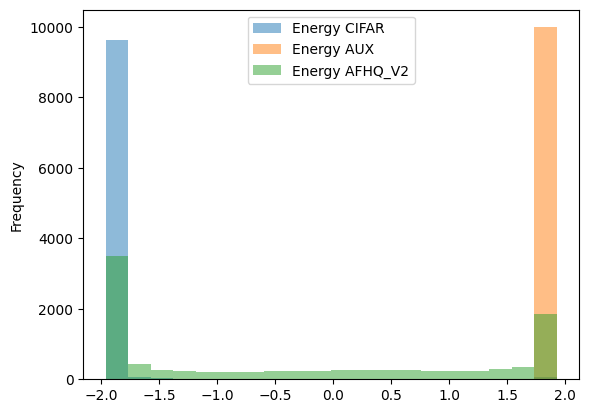

In [42]:
afhq_v2, afhq_v2_loader, afhq_v2_cifar_train_energy = eval_energy_model(
    data_path=AFHQV2_ROOT,
    energy_model=cifar_energy_model,
    )

plot_eval_hist(afhq_v2_cifar_train_energy, "Energy AFHQ_V2")    

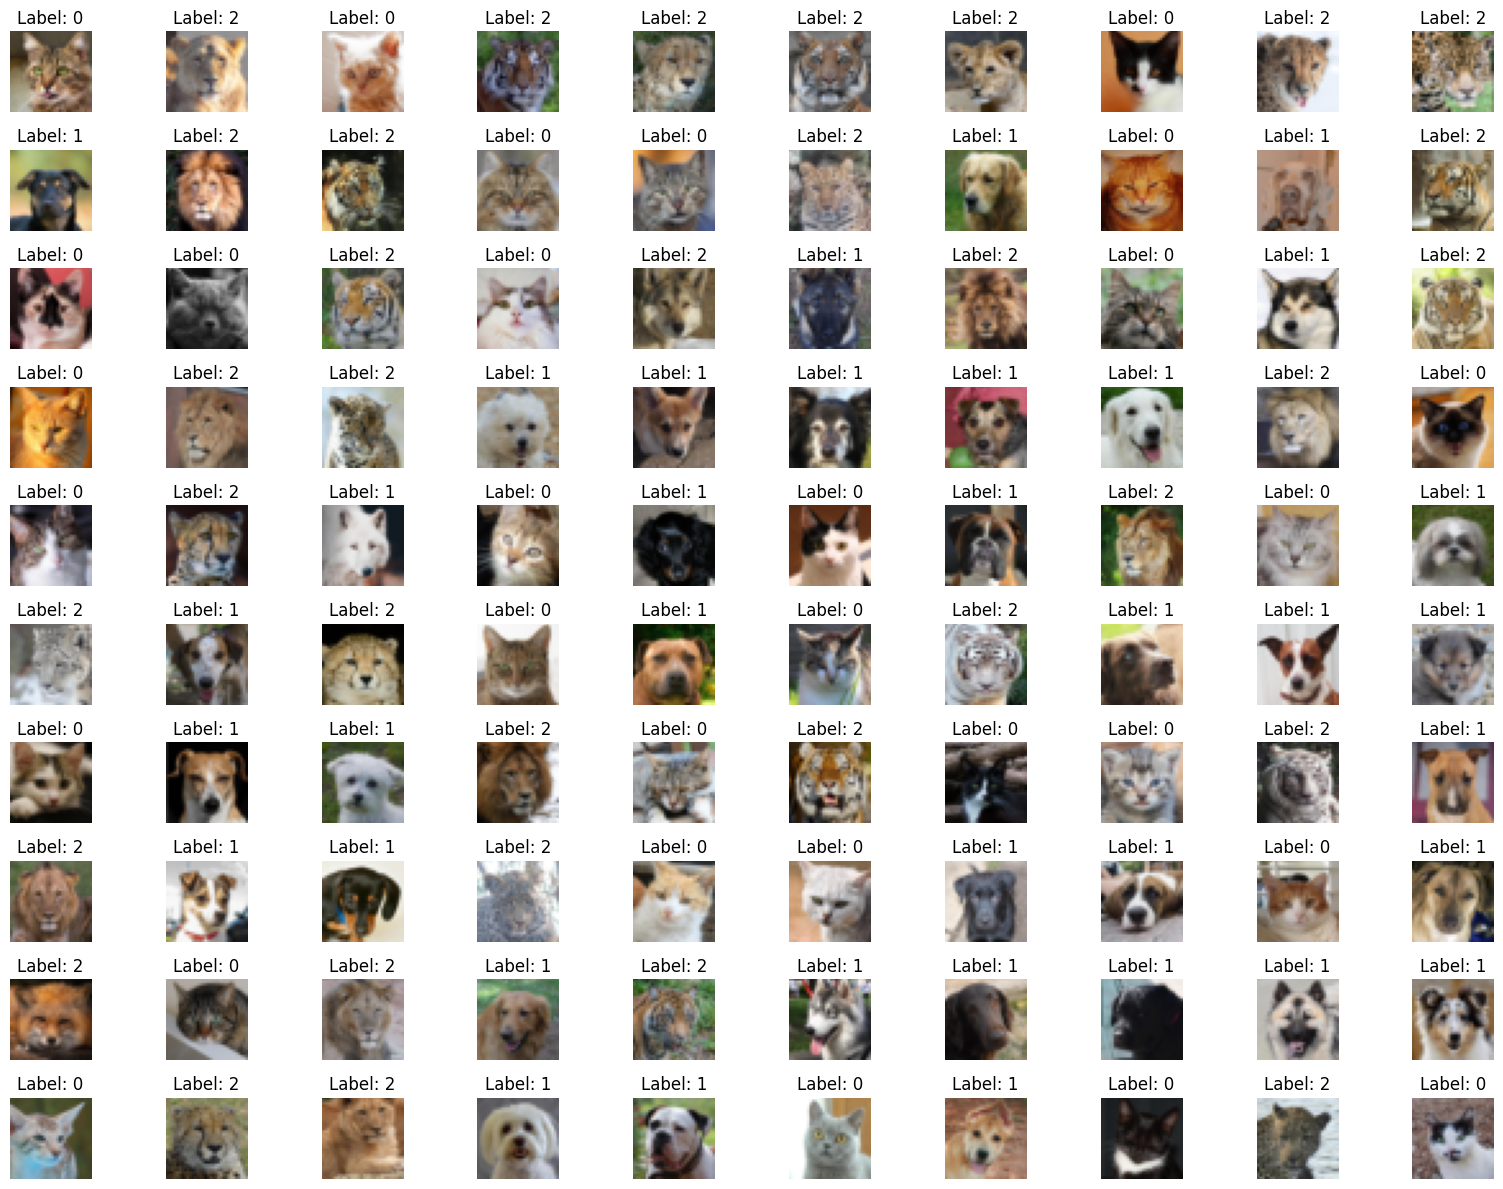

In [43]:
fig = plot_random_samples(afhq_v2, 100)

fig.set_size_inches(16, 12)
#plt.suptitle("Augmentation Effects on Hopfield Energy")

plt.tight_layout()
plt.show()

## Evaluation with tagged-anime-illustrations (moeimouto-faces) data set
https://www.kaggle.com/datasets/mylesoneill/tagged-anime-illustrations

AUROC: 0.9968345
FPR95: 0.0015
Wasserstein distance: 3.676521878921985


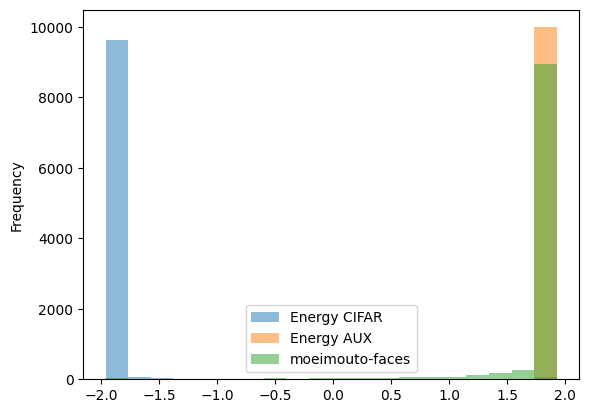

In [44]:
moeimouto_faces, moeimouto_faces_loader, moeimouto_faces_cifar_train_energy = eval_energy_model(
    data_path=MOEIMOUTO_FACES_ROOT,
    energy_model=cifar_energy_model,
    )

plot_eval_hist(moeimouto_faces_cifar_train_energy, "moeimouto-faces")    

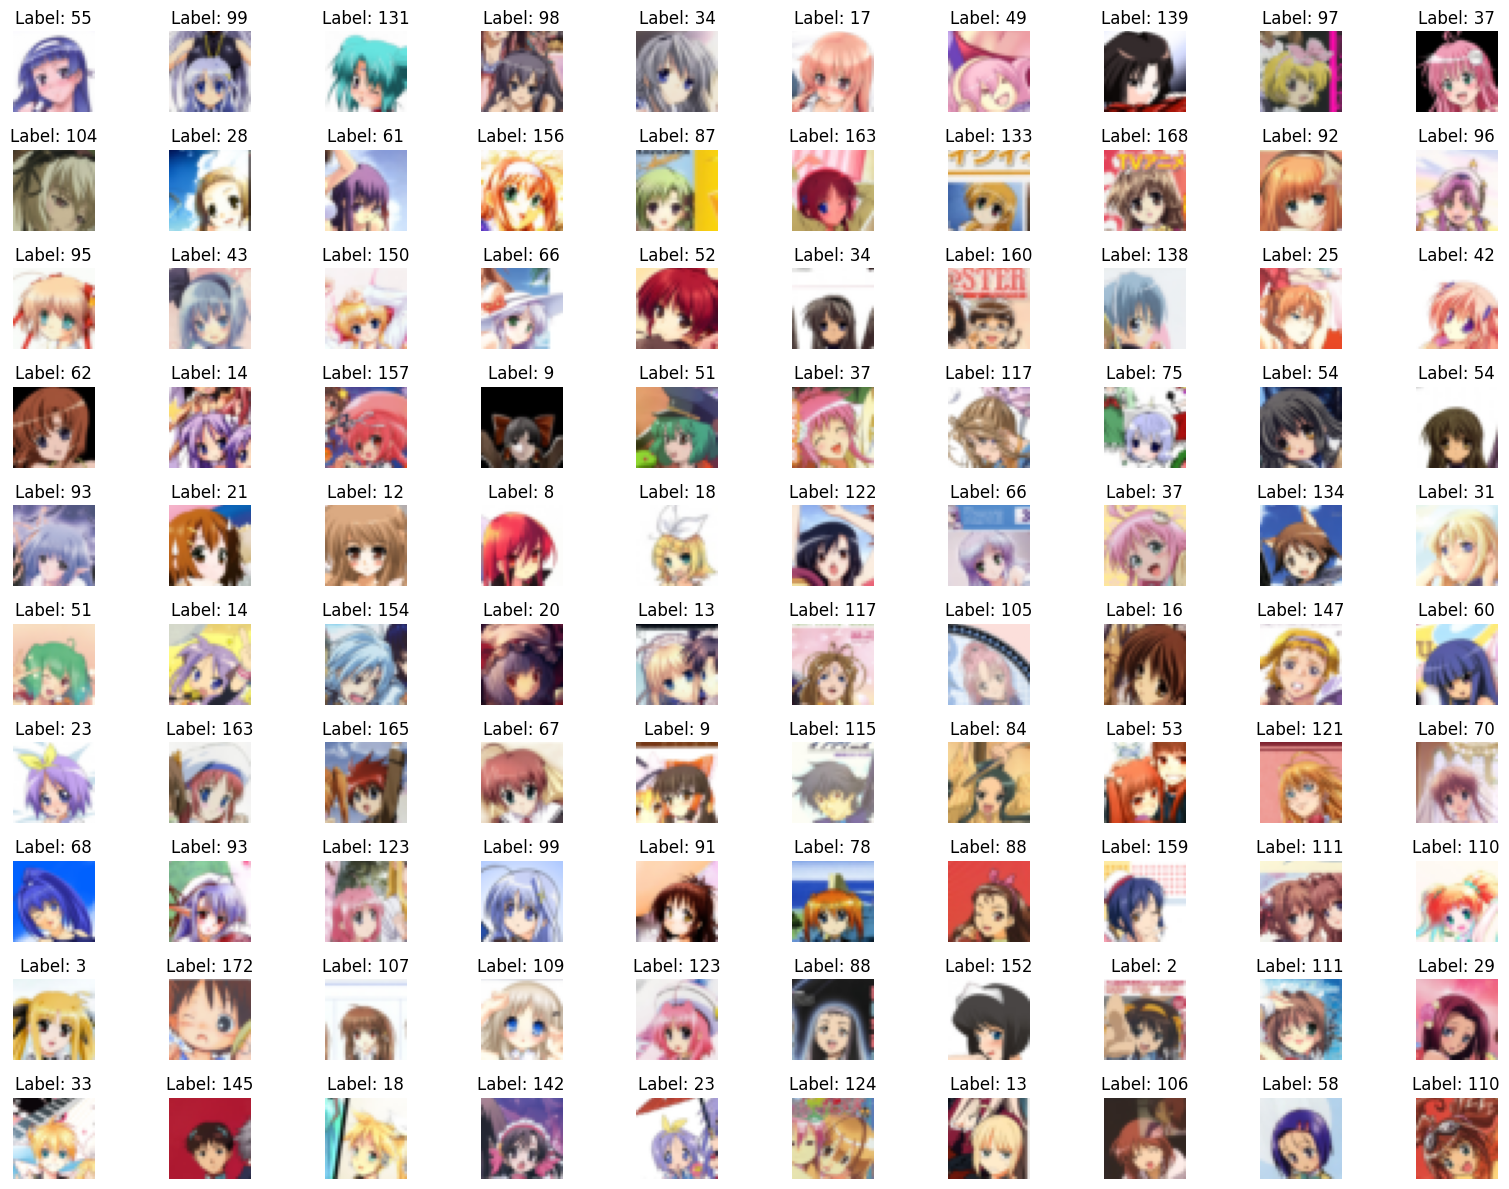

In [45]:
fig = plot_random_samples(moeimouto_faces, 100)

fig.set_size_inches(16, 12)
#plt.suptitle("Augmentation Effects on Hopfield Energy")

plt.tight_layout()
plt.show()

## Evaluation with natural adversarial example dataset ImageNet-O for out-of-distribution detectors
https://github.com/hendrycks/natural-adv-examples?tab=readme-ov-file

AUROC: 0.9907645350000001
FPR95: 0.0253
Wasserstein distance: 3.4119022530674936


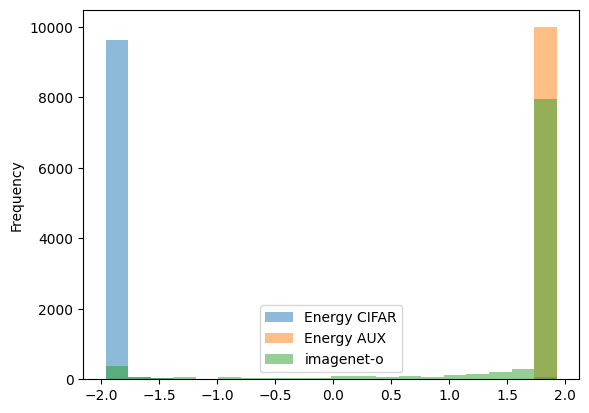

In [46]:
imageneto, imageneto_loader, imageneto_cifar_train_energy = eval_energy_model(
    data_path=IMAGENETO_ROOT,
    energy_model=cifar_energy_model,
    replace=True,
    )

plot_eval_hist(imageneto_cifar_train_energy, "imagenet-o")

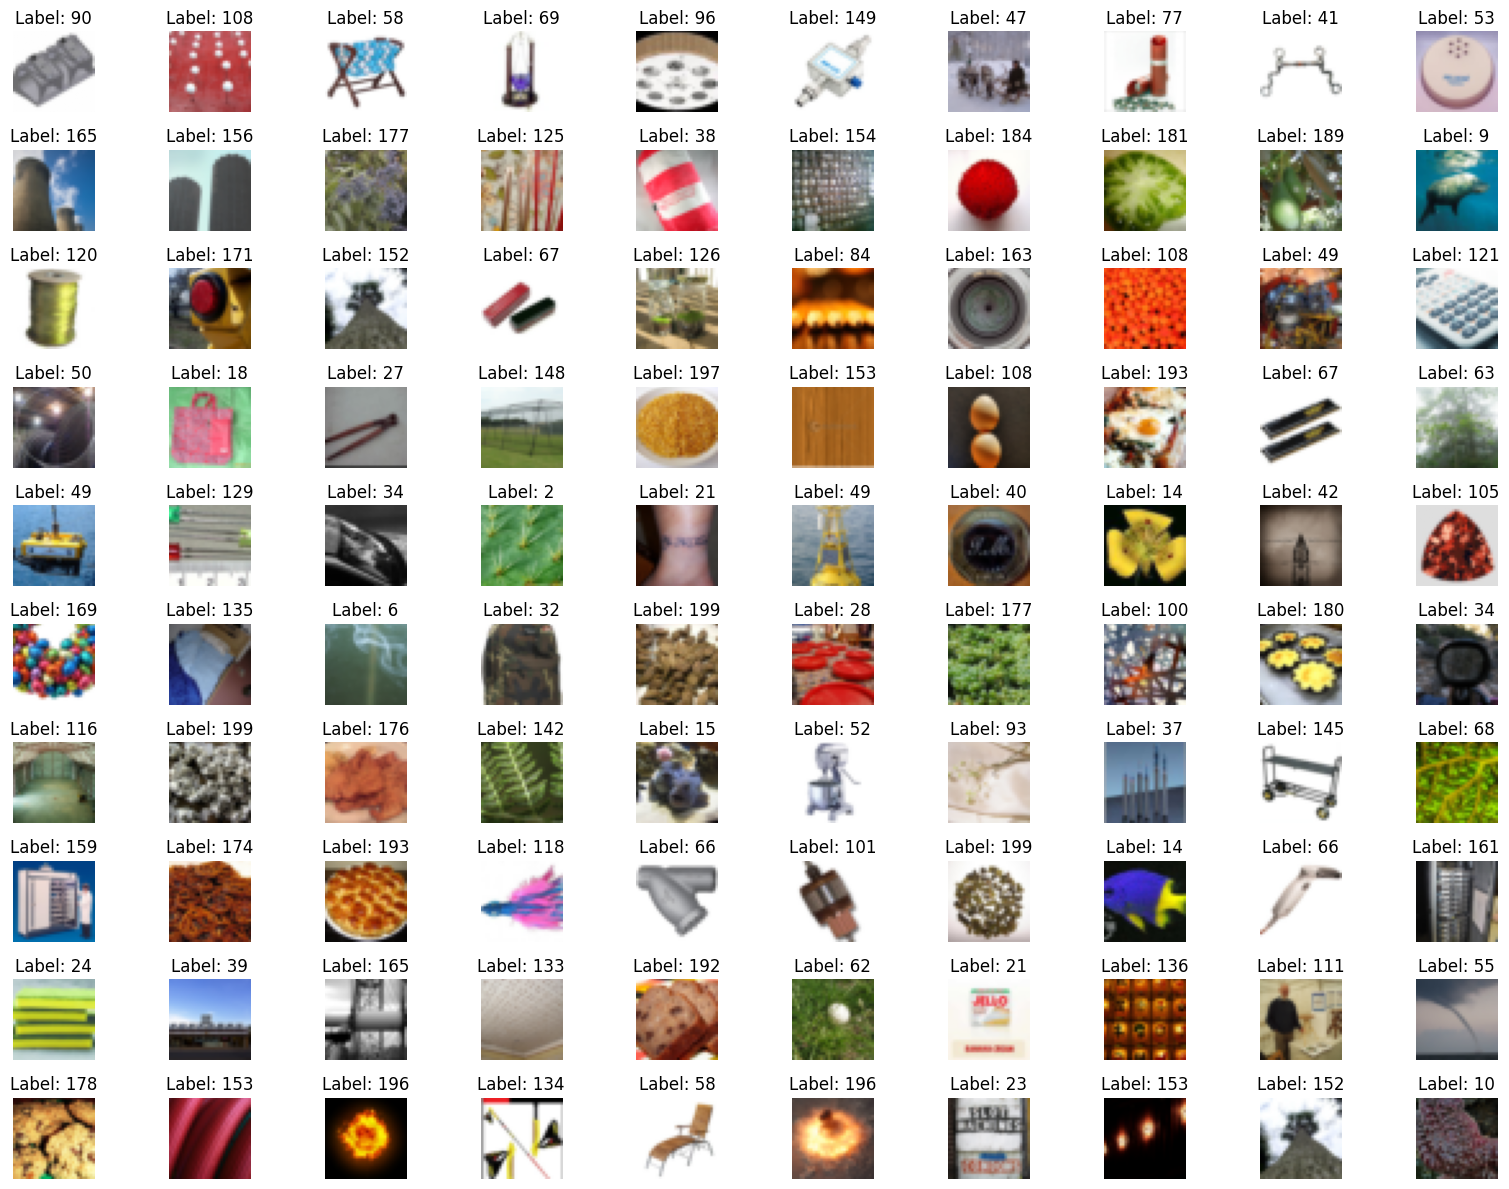

In [47]:
fig = plot_random_samples(imageneto, 100)

fig.set_size_inches(16, 12)
#plt.suptitle("Augmentation Effects on Hopfield Energy")

plt.tight_layout()
plt.show()